<a href="https://colab.research.google.com/github/debu-sinha/building-ai-agents/blob/main/Custom_Agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [78]:
# Create a custom agent using langchain to order laptop. Use langgraph and langchain.
# We will use the same dataset as the previous notebooks. We will create a laptop orders agent.
# Install all dependency packages
# Remember to execute this before running any of the exercises

!pip install langchain
!pip install langchain-openai
!pip install langchain_community
!pip install langchain_chroma
!pip install langgraph
!pip install tenacity
!pip install pysqlite3-binary
!pip install pandas
!pip install pypdf
!pip install nbforma

ERROR: Could not find a version that satisfies the requirement nbforma (from versions: none)
ERROR: No matching distribution found for nbforma


In [79]:
# Import the right modules and import the required libraries
# Initialize the right models for our chatbot
from langchain_core.messages import HumanMessage, SystemMessage, AnyMessage, ToolMessage, AIMessage
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

from google.colab import userdata

chat_model = ChatOpenAI(
    model_name="gpt-4o", # Changed model name to gpt-4o
    openai_api_key=userdata.get('oai')
)

embedding_model = OpenAIEmbeddings(
    model="text-embedding-3-small",
    api_key=userdata.get('oai')
)

# Test the models
# print(chat_model.invoke("how do you do?"))
# print(embedding_model.embed_query("how do you do?"))

In [80]:
from langchain_core.tools import tool
import pandas as pd

product_orders_df = pd.read_csv("./data/Laptop Orders.csv")
print(product_orders_df)

@tool
def get_order_details(order_id:str) -> str :
    """
    This function returns details about a laptop order, given an order ID
    It performs an exact match between the input order id and available order ids
    If a match is found, it returns products (laptops) ordered, quantity ordered and delivery date.
    If there is NO match found, it returns -1
    """
    # Filter Dataframe for order ID
    match_order_df = product_orders_df[
                        product_orders_df["Order ID"] == order_id ]

    # Check if a record was found, if not return -1
    if len(match_order_df) == 0 :
        return -1
    else:
        return match_order_df.iloc[0].to_dict()

@tool
def update_quantity(order_id:str, new_quantity:int) -> bool :
    """
    This function updates the quantity of products ( laptops ) ordered for a given order Id.
    It there are no matching orders, it returns False.
    """
    # Find if matching record exists
    match_order_df = product_orders_df[
                        product_orders_df["Order ID"] == order_id ]

    # Check if a record was found, if not return -1
    if len(match_order_df) == 0 :
        return False
    else:
        product_orders_df.loc[
            product_orders_df["Order ID"] == order_id,
                "Quantity Ordered"] = new_quantity
        return True

# print(get_order_details("ORD-7311"))
# print(update_quantity("ORD-7311", 10))
# print(product_orders_df)

   Order ID Product Ordered  Quantity Ordered Delivery Date
0  ORD-8276   SpectraBook S                 3    2024-10-16
1  ORD-6948    OmegaPro G17                 3    2024-10-25
2  ORD-7311   NanoEdge Flex                 2    2024-10-19
3  ORD-4633    OmegaPro G17                 2    2024-10-15
4  ORD-2050      GammaAir X                 2    2024-10-26


In [81]:
from typing_extensions import TypedDict, Annotated
import operator
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import MemorySaver

class Orders_Agent_State(TypedDict):
  messages: Annotated[list[AnyMessage], operator.add]

class Custom_Product_Orders_Agent:

  def __init__(self, system_prompt, chat_model, tools, debug=False):
    self.system_prompt = system_prompt
    self.debug = debug

    agent_graph = StateGraph(Orders_Agent_State)
    agent_graph.add_node("orders_llm", self.call_llm)
    agent_graph.add_node("orders_tools", self.call_tools)
    agent_graph.add_conditional_edges(
        "orders_llm",
        self.is_tool_call,
        {True: "orders_tools", False: END}
    )
    agent_graph.add_edge("orders_tools", "orders_llm") # Add edge back to LLM after tool call
    agent_graph.set_entry_point("orders_llm")

    self.memory = MemorySaver()
    self.agent = agent_graph.compile(checkpointer=self.memory)

    self.tools = { tool.name : tool for tool in tools}
    if self.debug:
      print("Agent Initialized")
      print(f"Tools loaded : {self.tools}")

     # Bind the tools to our model
    self.model =  chat_model.bind_tools(tools)

  def call_llm(self, state: Orders_Agent_State):
    messages = state["messages"]

    if self.system_prompt:
      messages = [SystemMessage(content=self.system_prompt)] + messages

    result = self.model.invoke(messages)
    if self.debug:
      print(f"Raw LLM Result in call_llm: {result}")
    return {"messages":[result]}

  def is_tool_call(self, state: Orders_Agent_State):
    messages = state["messages"]
    last_message = messages[-1]

    # print(f"Last message type in is_tool_call: {type(last_message)}") # Added print statement
    # print(f"Last message content in is_tool_call: {last_message.content}") # Added print statement
    # print(f"Last message tool_calls attribute in is_tool_call: {hasattr(last_message, 'tool_calls')}") # Added print statement

    # If tool action is requested
    if isinstance(last_message, AIMessage) and hasattr(last_message, 'tool_calls') and last_message.tool_calls: # More robust check
      # print("Detected tool call.") # Added print statement
      return True
    else:
      # print("No tool call detected.") # Added print statement
      return False

  def call_tools(self, state: Orders_Agent_State):
    messages = state["messages"]
    last_message = messages[-1]

    # print(last_message)
    tool_calls = last_message.tool_calls
    tool_outputs = []

    for tool in tool_calls:
      if not tool["name"] in self.tools:
        # print(f"Unknown tool name {tool}")
        result = "Invalid Tool. Please Retry."
      else:
        result = self.tools[tool["name"]].invoke(tool["args"])

      tool_outputs.append(ToolMessage(tool_call_id=tool["id"], name=tool["name"], content=str(result)))
      if self.debug:
        print(f"\nTools returned {tool_outputs}")

    return {"messages": tool_outputs}

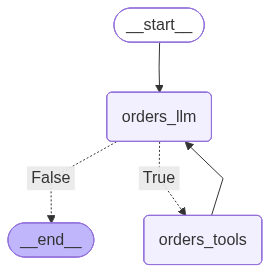

In [82]:
from IPython.display import Image

#Note that this is a string, since the model init only accepts a string.
system_prompt = """
    You are professional chatbot that manages orders for laptops sold by our company.
    You have access to tools that allow for retrieving order details and updating order quantity.
    When a user asks for order details for a specific order ID, **you MUST use the `get_order_details` tool** to retrieve the information and provide it to the user.
    When a user asks to update the quantity of an order, **you MUST use the `update_quantity` tool**.
    Do NOT reveal information about other orders than the one requested.
    You will handle small talk and greetings by producing professional responses, but prioritize using the tools when the user asks about orders.
    """

#Create the custom orders agent
orders_agent = Custom_Product_Orders_Agent(system_prompt=system_prompt,
                                           chat_model=chat_model,
                           tools=[get_order_details, update_quantity],
                           debug=False)

#Visualize the Agent
Image(orders_agent.agent.get_graph().draw_mermaid_png())

In [83]:
import uuid
#Send a sequence of messages to chatbot and get its response
#This simulates the conversation between the user and the Agentic chatbot
user_inputs = [
    "How are you doing?",
    "Please show me the details of the order ORD-7311",
    "Can you add one more of that laptop to the order? ",
    "Can you show me the details again ? ",
    "What about order ORD-9999 ?",
    "Bye"
]

#Create a new thread
config = {"configurable": {"thread_id": str(uuid.uuid4())}}

for input in user_inputs:
    print(f"----------------------------------------\nUSER : {input}")
    #Format the user message
    user_message = {"messages":[HumanMessage(input)]}
    #Get response from the agent
    ai_response = orders_agent.agent.invoke(user_message,config=config)
    #Print the response
    print(f"\nAGENT : {ai_response['messages'][-1].content}")



----------------------------------------
USER : How are you doing?

AGENT : I'm here and ready to help you with any questions or requests you have regarding your laptop orders. How can I assist you today?
----------------------------------------
USER : Please show me the details of the order ORD-7311

AGENT : Here are the details for order ID **ORD-7311**:
- **Product Ordered:** NanoEdge Flex
- **Quantity Ordered:** 2
- **Delivery Date:** 2024-10-19

If you have any other questions or need further assistance, feel free to let me know!
----------------------------------------
USER : Can you add one more of that laptop to the order? 

AGENT : The quantity for order ID **ORD-7311** has been successfully updated to 3. If there's anything else you need, just let me know!
----------------------------------------
USER : Can you show me the details again ? 

AGENT : Here are the updated details for order ID **ORD-7311**:
- **Product Ordered:** NanoEdge Flex
- **Quantity Ordered:** 3
- **Delive